In [ ]:
import sys
import os
from pathlib import Path
sys.path.append(str(Path().resolve().parent))
sys.path.insert(0,  os.path.dirname(os.path.dirname(os.getcwd()) ))
from Dataset import SROIEDataset2
from torch.utils.data import DataLoader
from tqdm import tqdm
from ctpn_model import *
from task1_utils.ctpn_utils import *
from PIL import Image


model = CTPN_Model()
checkpoint = torch.load('best_ctpn_model.pth',
                        map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])


/Users/kimelfeld/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kimelfeld/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [2]:
checkpoint['val_loss']

0.7417455837130547

In [6]:
checkpoint['history']['val_total'], checkpoint['history']['train_total']



([0.8213105276226997,
  1.5501708537340164,
  1.0630016326904297,
  0.8986348509788513,
  0.7417455837130547],
 [0.903908350937803,
  1.0187453913017057,
  1.0998409826990585,
  0.9683523316618422,
  0.805649544571487])

In [5]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [5]:
test_dataset = SROIEDataset2(None, '../../data/test/img','../../data/test/box', )
train_dataset = SROIEDataset2('train','../../data/train/img','../../data/train/box',  )

In [8]:
from task1_utils.ctpn_utils import *
import numpy
import matplotlib.pyplot as plt

def quads_to_boxes(text):
    boxes = []
    for t in text:
        # t[:8] содержит 8 координат: x1, y1, x2, y2, x3, y3, x4, y4
        coords = t[:8]
        
        # Разделяем координаты на X и Y
        x_coords = [coords[i] for i in range(0, 8, 2)]  # x1, x2, x3, x4
        y_coords = [coords[i] for i in range(1, 8, 2)]  # y1, y2, y3, y4
        
        # Находим min и max для каждой оси
        x_min = min(x_coords)
        y_min = min(y_coords)
        x_max = max(x_coords)
        y_max = max(y_coords)
        
        boxes.append([x_min, y_min, x_max, y_max,])
    
    return boxes

def pred_box_postproccesing(image, model, prob_thresh, iou_tresh):
    image = image.unsqueeze(0).to(device)
    cls, regr = model(image)
    cls_prob = F.softmax(cls, dim=-1).detach().numpy()
    regr = regr.detach().numpy()
    h, w = 640, 640
    #
    anchor = gen_anchor((int(h / 8), int(w / 8)), 8)
    bbox = bbox_transfor_inv(anchor, regr)
    bbox = clip_box(bbox, [h, w])
    fg = np.where(cls_prob[0, :, 1] > prob_thresh)[0]
    select_anchor = bbox[fg, :]
    select_score = cls_prob[0, fg, 1]
    select_anchor = select_anchor.astype(np.int32)
    keep_index = filter_bbox(select_anchor, 8)

    # nsm
    select_anchor = select_anchor[keep_index]
    select_score = select_score[keep_index]
    select_score = np.reshape(select_score, (select_score.shape[0], 1))
    nmsbox = np.hstack((select_anchor, select_score))
    keep = nms(nmsbox, iou_tresh)

    select_anchor = select_anchor[keep]
    select_score = select_score[keep]

    # text line-
    textConn = TextProposalConnectorOriented()
    text = textConn.get_text_lines(select_anchor, select_score, [h, w])
    nms_boxes = quads_to_boxes(text)
    return nms_boxes
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


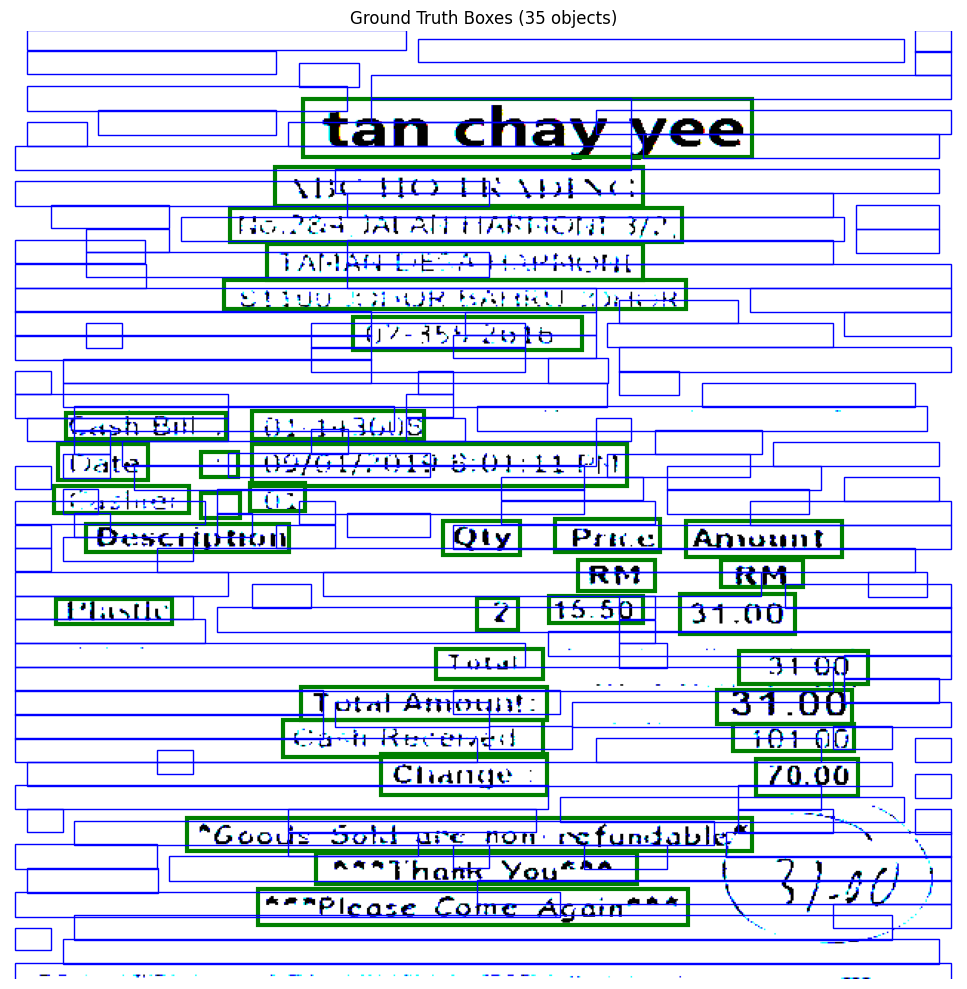

In [15]:
def visualize_sample_data(m_img, gtbox, pred_gtbox):
    """
    Визуализация данных из одного сэмпла датасета
    
    Args:
        m_img: нормализованное изображение [3, H, W] или [H, W, 3]
        cls: классификатор анкоров
        regr: регрессия анкоров  
        gtbox: ground truth boxes [num_boxes, 4] в формате (x1, y1, x2, y2)
    """


    # Обрезаем значения и конвертируем
    img_np =  np.transpose(m_img.cpu().numpy(), (1, 2, 0))

    # 2. Создаем визуализацию
    #print(m_img.shape)

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    
    # 2a. Левая панель: только GT boxes
    ax.imshow(img_np,)

    if gtbox is not None and len(gtbox) > 0:
        gtbox_np = gtbox if isinstance(gtbox, np.ndarray) else gtbox
        
        for i, box in enumerate(gtbox_np):
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            
            rect = plt.Rectangle(
                (x1, y1), width, height,
                fill=False, edgecolor='green', linewidth=3,
                label='Ground Truth' if i == 0 else ""
            )
            ax.add_patch(rect)

    if pred_gtbox is not None and len(pred_gtbox) > 0:
        gtbox_np = pred_gtbox if isinstance(pred_gtbox, np.ndarray) else pred_gtbox
        
        for i, box in enumerate(gtbox_np):
            x1, y1, x2, y2  = box
            width = x2 - x1
            height = y2 - y1
            
            rect = plt.Rectangle(
                (x1, y1), width, height,
                fill=False, edgecolor='blue', linewidth=1,
                label='Ground Truth' if i == 0 else ""
            )
            ax.add_patch(rect)
    
    ax.set_title(f'Ground Truth Boxes ({len(gtbox) if gtbox is not None else 0} objects)')
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

all_pred_boxes = []
all_gt_boxes = []
m_img, _, _, gtboxes = train_dataset[5]

pred_boxes = pred_box_postproccesing(m_img, model, iou_tresh=0.01, prob_thresh=0.38)
            
m_img, _, _, true_boxes = train_dataset[5]
visualize_sample_data(m_img, gtboxes.tolist(), pred_boxes)

In [11]:
from task1_utils.metrics import compute_f1_for_image, compute_f1_score

compute_f1_for_image(gtboxes.tolist(), pred_boxes)


(6, 41, 134)

In [ ]:
all_gt_boxes=[]
all_pred_boxes=[]

for m_img, _, _, gtboxes in test_dataset:
    pred_boxes = pred_box_postproccesing(m_img, model, iou_tresh=0.01, prob_thresh=0.38)
    all_gt_boxes.append(gtboxes)
    all_pred_boxes.append(pred_boxes)
    
compute_f1_score( all_pred_boxes, all_gt_boxes)

Corrupt JPEG data: bad Huffman code


0.0212325440711614